In [1]:
# pip install --upgrade tensorflow
%matplotlib inline
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
# !pip install tensorflow
# !pip install keras_tuner

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

lw = 1 # line weight for plt
BATCH_SIZE = 32 # Model batch size
EPOCHS = 100 # Model number of epoch 
MODELS_RESULTS={} # store for all model result for both balanced and resampled datasets
n_classes=10
num_columns = 42  # Number of columns in df
regularizers=tf.keras.regularizers.l2(0.001)
print(tf.__version__)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['savefig.dpi'] = 500

2.7.0


In [3]:
# importing the train and test data dataset from file
train_val_csv = pd.read_csv('./data/UNSW_NB15_training-set.csv')
test_csv = pd.read_csv('./data/UNSW_NB15_testing-set.csv')

In [4]:
train_val=train_val_csv.drop(columns=['id','label'])
test=test_csv.drop(columns=['id','label'])

In [5]:
# Split the data into train and test with 80 train / 20 test
train,val = train_test_split(train_val, test_size=0.2, random_state = 1)

In [6]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

65865 training examples
16467 validation examples
175341 test examples


In [7]:
CLASSES=['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']
print(CLASSES)
# # five metrics used for evaluation process
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Backdoor', 'Reconnaissance', 'Analysis', 'Shellcode', 'Worms']


In [8]:
def plot_chart(history,name):
    plt.figure(figsize=(10, 10))
    names =['loss','accuracy']
    c=0
    for n in names:
        c=c+1
        n_val = 'val_'+n
        hist = history.history[n]
        hist_val = history.history[n_val]
        plt.subplot(len(names),1,c)
        plt.plot(hist, label='Training {}'.format(n))
        plt.plot(hist_val, label='Validation {}'.format(n))
        plt.legend(loc='lower right')
        plt.ylabel(n)
        plt.ylim(0.4,1)
        plt.title('{} Training and Validation {}'.format(name,n))
    plt.xlabel('epoch')
    return plt

In [9]:
def group_by_data_type(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result

In [10]:
def df_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels=dataframe.pop('attack_cat')
    y=tf.keras.utils.to_categorical(labels, num_classes=10)
    X=tf.convert_to_tensor(dataframe)
    return X,y

In [11]:
def number_col_process(data):
    normalized_df=(data-data.mean())/data.std()
    return normalized_df

In [12]:
def int_category_col_process(data):
    print('process string_category_col')
    columns=data.columns.values
    for col in columns:
        codes, uniques = pd.factorize(data[col])
        data[col] = codes
    return data

In [13]:
def string_category_col_process(data):
    columns=data.columns.values
    for col in columns:
        encoder_col = encoder.fit_transform(data[[col]]).toarray()
        data[col] = encoder_col
    return data

In [14]:
def labels_process(data):
    data['attack_cat'] = data['attack_cat'].map(CLASSES.index)
    return data

In [15]:
def process_data(df,data_types):
    result= df.copy()
    for name in data_types:
        print(name)
        types = data_types[name]
        selected_df = df[types]
        if name =='number_col':
            data = number_col_process(selected_df)
        if name =='int_category_col':
            data = int_category_col_process(selected_df)
        if name =='string_category_col':
            data = string_category_col_process(selected_df)
        if name =='labels':
            data = labels_process(selected_df)
        for tp in types:
            result[tp]=data[tp]
    return result

In [16]:
train_df = train.copy();
val_df = val.copy();
test_df = test.copy();
# seperate the structured data into individal type
data_types = group_by_data_type(train_df) # return result from

In [17]:
# model fix, compyling and visualisation 
# TRADITIONAL-NETWORK
df = train_df.copy()
_ds= process_data(df,data_types)
X_train,y_train= df_to_dataset(_ds)

number_col
string_category_col
int_category_col
process string_category_col
labels


In [18]:
df = val_df.copy()
_ds= process_data(df,data_types)
X_val,y_val= df_to_dataset(_ds)

number_col
string_category_col
int_category_col
process string_category_col
labels


In [19]:
df = test_df.copy()
_ds= process_data(df,data_types)
X_test,y_test= df_to_dataset(_ds)

number_col
string_category_col
int_category_col
process string_category_col
labels


In [20]:
# # Load some data
def build_model(hp):
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layer for numeric data
    inputs = keras.Input(shape=(42,), name='inputs')
   
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    x = layers.Dense(hp_units_1,activation='relu',kernel_regularizer=regularizers)(inputs)
    x = layers.Dropout(0.5)(x)
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_2,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    x = layers.Dense(units=hp_units_3,activation='relu',kernel_regularizer=regularizers)(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(n_classes, activation="softmax")(x)
    model = keras.Model(inputs,output)
    print('MODAL-SUMMARY')
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.CategoricalCrossentropy(), metrics=METRICS)
    return model

In [21]:
print('TRADITIONAL-NETWORK')
name='TRADITIONAL-NETWORK'
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
print('fit model for:{}_____________________________________________________________________________________________________________'.format(name))
MODELS_RESULTS[name]={}
project_name='HYPERPARAM_'+name
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperparam_dir',
                     project_name=project_name)
print('----')
#     early stoppping if val_loss is behaving poorly
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     hyperparameter search based on 50 epochs
tuner.search(X_train, y_train, epochs=50, validation_data=[X_val,y_val], callbacks=[stop_early])
    # Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print('----')
history = model.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val,y_val])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(X_train,y_train, batch_size=BATCH_SIZE, epochs=best_epoch, validation_data=[X_val,y_val])
print('evaluation result model for:{} on TRAIN_________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_train,y_train)
MODELS_RESULTS[name]['train']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on VALIDATION________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_val,y_val)
MODELS_RESULTS[name]['validation']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('evaluation result model for:{} on TEST________________________________________________________________________________'.format(name))
loss,accuracy,precision,recall,auc,prc = hypermodel.evaluate(X_test,y_test)
MODELS_RESULTS[name]['test']={'loss':loss,'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc,'prc':prc}
print('loss:{} -accuracy:{} - precision:{} - recall:{} - auc:{} - prc:{}'.format(loss,accuracy,precision,recall,auc,prc))
print('----')
print('----')
print('plot:{}_________________________________________________________'.format(name))

Trial 30 Complete [00h 02m 03s]
val_accuracy: 0.6822736263275146

Best val_accuracy So Far: 0.6834274530410767
Total elapsed time: 00h 15m 24s
INFO:tensorflow:Oracle triggered exit
MODAL-SUMMARY
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 42)]              0         
                                                                 
 dense_4 (Dense)             (None, 480)               20640     
                                                                 
 dropout_3 (Dropout)         (None, 480)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               61568     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                              

2059/2059 [==============================] - 6s 3ms/step - loss: 0.9397 - accuracy: 0.7169 - precision: 0.7481 - recall: 0.6877 - auc: 0.9514 - prc: 0.7597 - val_loss: 1.2542 - val_accuracy: 0.6810 - val_precision: 0.7067 - val_recall: 0.6630 - val_auc: 0.9286 - val_prc: 0.6949
Epoch 24/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9244 - accuracy: 0.7162 - precision: 0.7485 - recall: 0.6879 - auc: 0.9517 - prc: 0.7604 - val_loss: 1.3482 - val_accuracy: 0.6804 - val_precision: 0.7187 - val_recall: 0.6499 - val_auc: 0.9278 - val_prc: 0.6949
Epoch 25/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9281 - accuracy: 0.7162 - precision: 0.7478 - recall: 0.6875 - auc: 0.9516 - prc: 0.7592 - val_loss: 1.3757 - val_accuracy: 0.6809 - val_precision: 0.7183 - val_recall: 0.6498 - val_auc: 0.9279 - val_prc: 0.6944
Epoch 26/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9226 - accuracy: 0.7161 - precision: 0.7479 - recall: 0.6

2059/2059 [==============================] - 6s 3ms/step - loss: 0.9204 - accuracy: 0.7161 - precision: 0.7487 - recall: 0.6878 - auc: 0.9517 - prc: 0.7604 - val_loss: 1.3873 - val_accuracy: 0.6815 - val_precision: 0.7187 - val_recall: 0.6494 - val_auc: 0.9266 - val_prc: 0.6922
Epoch 52/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9260 - accuracy: 0.7171 - precision: 0.7485 - recall: 0.6886 - auc: 0.9518 - prc: 0.7609 - val_loss: 1.3240 - val_accuracy: 0.6822 - val_precision: 0.7180 - val_recall: 0.6517 - val_auc: 0.9284 - val_prc: 0.6938
Epoch 53/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9313 - accuracy: 0.7163 - precision: 0.7483 - recall: 0.6883 - auc: 0.9516 - prc: 0.7600 - val_loss: 1.3826 - val_accuracy: 0.6822 - val_precision: 0.7183 - val_recall: 0.6501 - val_auc: 0.9288 - val_prc: 0.6945
Epoch 54/100
2059/2059 [==============================] - 7s 3ms/step - loss: 0.9450 - accuracy: 0.7168 - precision: 0.7481 - recall: 0.6

2059/2059 [==============================] - 6s 3ms/step - loss: 0.9276 - accuracy: 0.7156 - precision: 0.7485 - recall: 0.6878 - auc: 0.9517 - prc: 0.7603 - val_loss: 1.3169 - val_accuracy: 0.6819 - val_precision: 0.7198 - val_recall: 0.6495 - val_auc: 0.9283 - val_prc: 0.6932
Epoch 80/100
2059/2059 [==============================] - 6s 3ms/step - loss: 1.0127 - accuracy: 0.7165 - precision: 0.7483 - recall: 0.6876 - auc: 0.9515 - prc: 0.7589 - val_loss: 1.3850 - val_accuracy: 0.6818 - val_precision: 0.7197 - val_recall: 0.6495 - val_auc: 0.9282 - val_prc: 0.6934
Epoch 81/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9812 - accuracy: 0.7156 - precision: 0.7479 - recall: 0.6873 - auc: 0.9514 - prc: 0.7592 - val_loss: 1.4484 - val_accuracy: 0.6801 - val_precision: 0.7112 - val_recall: 0.6564 - val_auc: 0.9278 - val_prc: 0.6929
Epoch 82/100
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9381 - accuracy: 0.7169 - precision: 0.7482 - recall: 0.6

2059/2059 [==============================] - 6s 3ms/step - loss: 1.3660 - accuracy: 0.6902 - precision: 0.7309 - recall: 0.6504 - auc: 0.9399 - prc: 0.7274 - val_loss: 1.4743 - val_accuracy: 0.6809 - val_precision: 0.7219 - val_recall: 0.6498 - val_auc: 0.9305 - val_prc: 0.6946
Epoch 3/55
2059/2059 [==============================] - 6s 3ms/step - loss: 1.2557 - accuracy: 0.7030 - precision: 0.7399 - recall: 0.6711 - auc: 0.9453 - prc: 0.7422 - val_loss: 1.4184 - val_accuracy: 0.6825 - val_precision: 0.7213 - val_recall: 0.6489 - val_auc: 0.9302 - val_prc: 0.6964
Epoch 4/55
2059/2059 [==============================] - 7s 3ms/step - loss: 1.2135 - accuracy: 0.7089 - precision: 0.7415 - recall: 0.6804 - auc: 0.9475 - prc: 0.7490 - val_loss: 1.4174 - val_accuracy: 0.6815 - val_precision: 0.7212 - val_recall: 0.6497 - val_auc: 0.9303 - val_prc: 0.6958
Epoch 5/55
2059/2059 [==============================] - 7s 3ms/step - loss: 1.1589 - accuracy: 0.7117 - precision: 0.7442 - recall: 0.6816 - 

2059/2059 [==============================] - 6s 3ms/step - loss: 0.9341 - accuracy: 0.7163 - precision: 0.7482 - recall: 0.6887 - auc: 0.9514 - prc: 0.7588 - val_loss: 1.3202 - val_accuracy: 0.6814 - val_precision: 0.7195 - val_recall: 0.6488 - val_auc: 0.9283 - val_prc: 0.6941
Epoch 31/55
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9992 - accuracy: 0.7164 - precision: 0.7486 - recall: 0.6882 - auc: 0.9515 - prc: 0.7599 - val_loss: 1.3255 - val_accuracy: 0.6825 - val_precision: 0.7181 - val_recall: 0.6498 - val_auc: 0.9281 - val_prc: 0.6940
Epoch 32/55
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9506 - accuracy: 0.7162 - precision: 0.7481 - recall: 0.6873 - auc: 0.9516 - prc: 0.7601 - val_loss: 1.3627 - val_accuracy: 0.6826 - val_precision: 0.7196 - val_recall: 0.6494 - val_auc: 0.9273 - val_prc: 0.6927
Epoch 33/55
2059/2059 [==============================] - 6s 3ms/step - loss: 0.9258 - accuracy: 0.7165 - precision: 0.7485 - recall: 0.6874

515/515 [==============================] - 1s 2ms/step - loss: 1.3664 - accuracy: 0.6814 - precision: 0.7156 - recall: 0.6517 - auc: 0.9265 - prc: 0.6898
loss:1.3663922548294067 -accuracy:0.6814234256744385 - precision:0.7156385183334351 - recall:0.6516669988632202 - auc:0.9265009760856628 - prc:0.6898188591003418
----
----
evaluation result model for:TRADITIONAL-NETWORK on TEST________________________________________________________________________________
5480/5480 [==============================] - 9s 2ms/step - loss: 2.3570 - accuracy: 0.3193 - precision: 0.3193 - recall: 0.3193 - auc: 0.7546 - prc: 0.2401
loss:2.356973171234131 -accuracy:0.31934913992881775 - precision:0.319347083568573 - recall:0.3193434476852417 - auc:0.7546100616455078 - prc:0.24010318517684937
----
----
plot:TRADITIONAL-NETWORK_________________________________________________________


<module 'matplotlib.pyplot' from '/Users/abiodunayantayo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

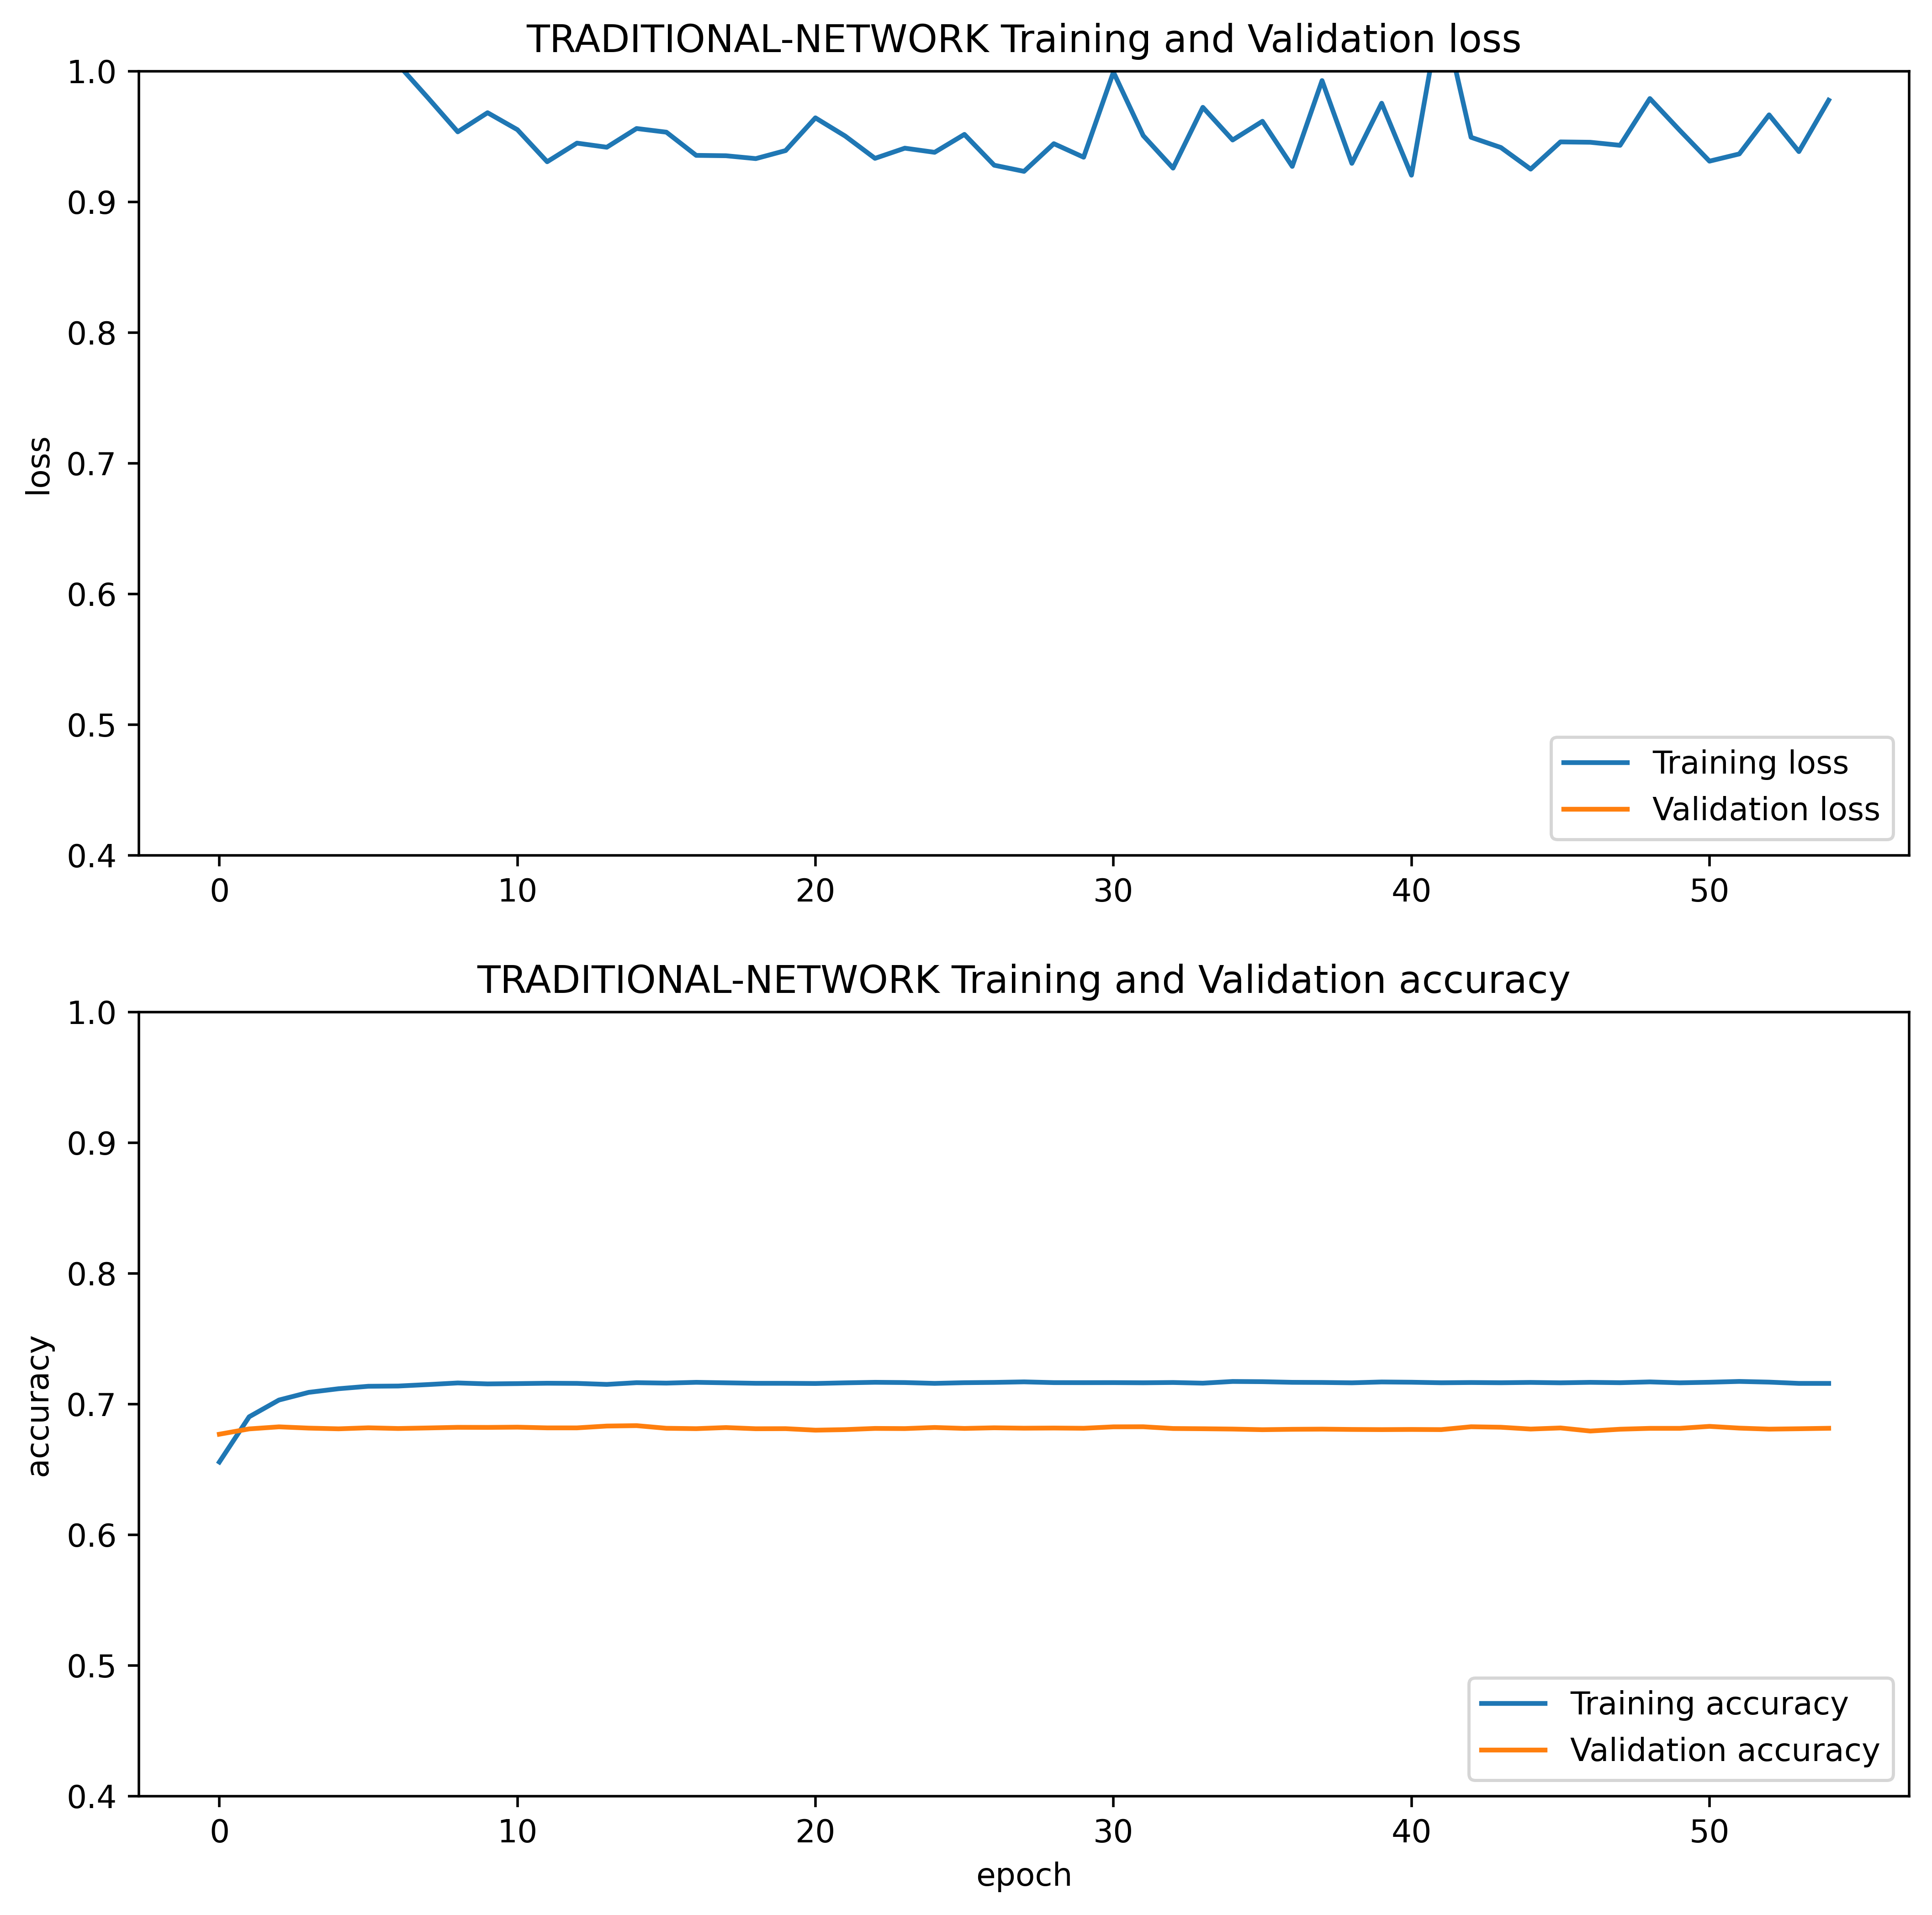

In [22]:
plot_chart(history,name)

In [23]:
y_pred = model.predict(X_test)

In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [25]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)


for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes

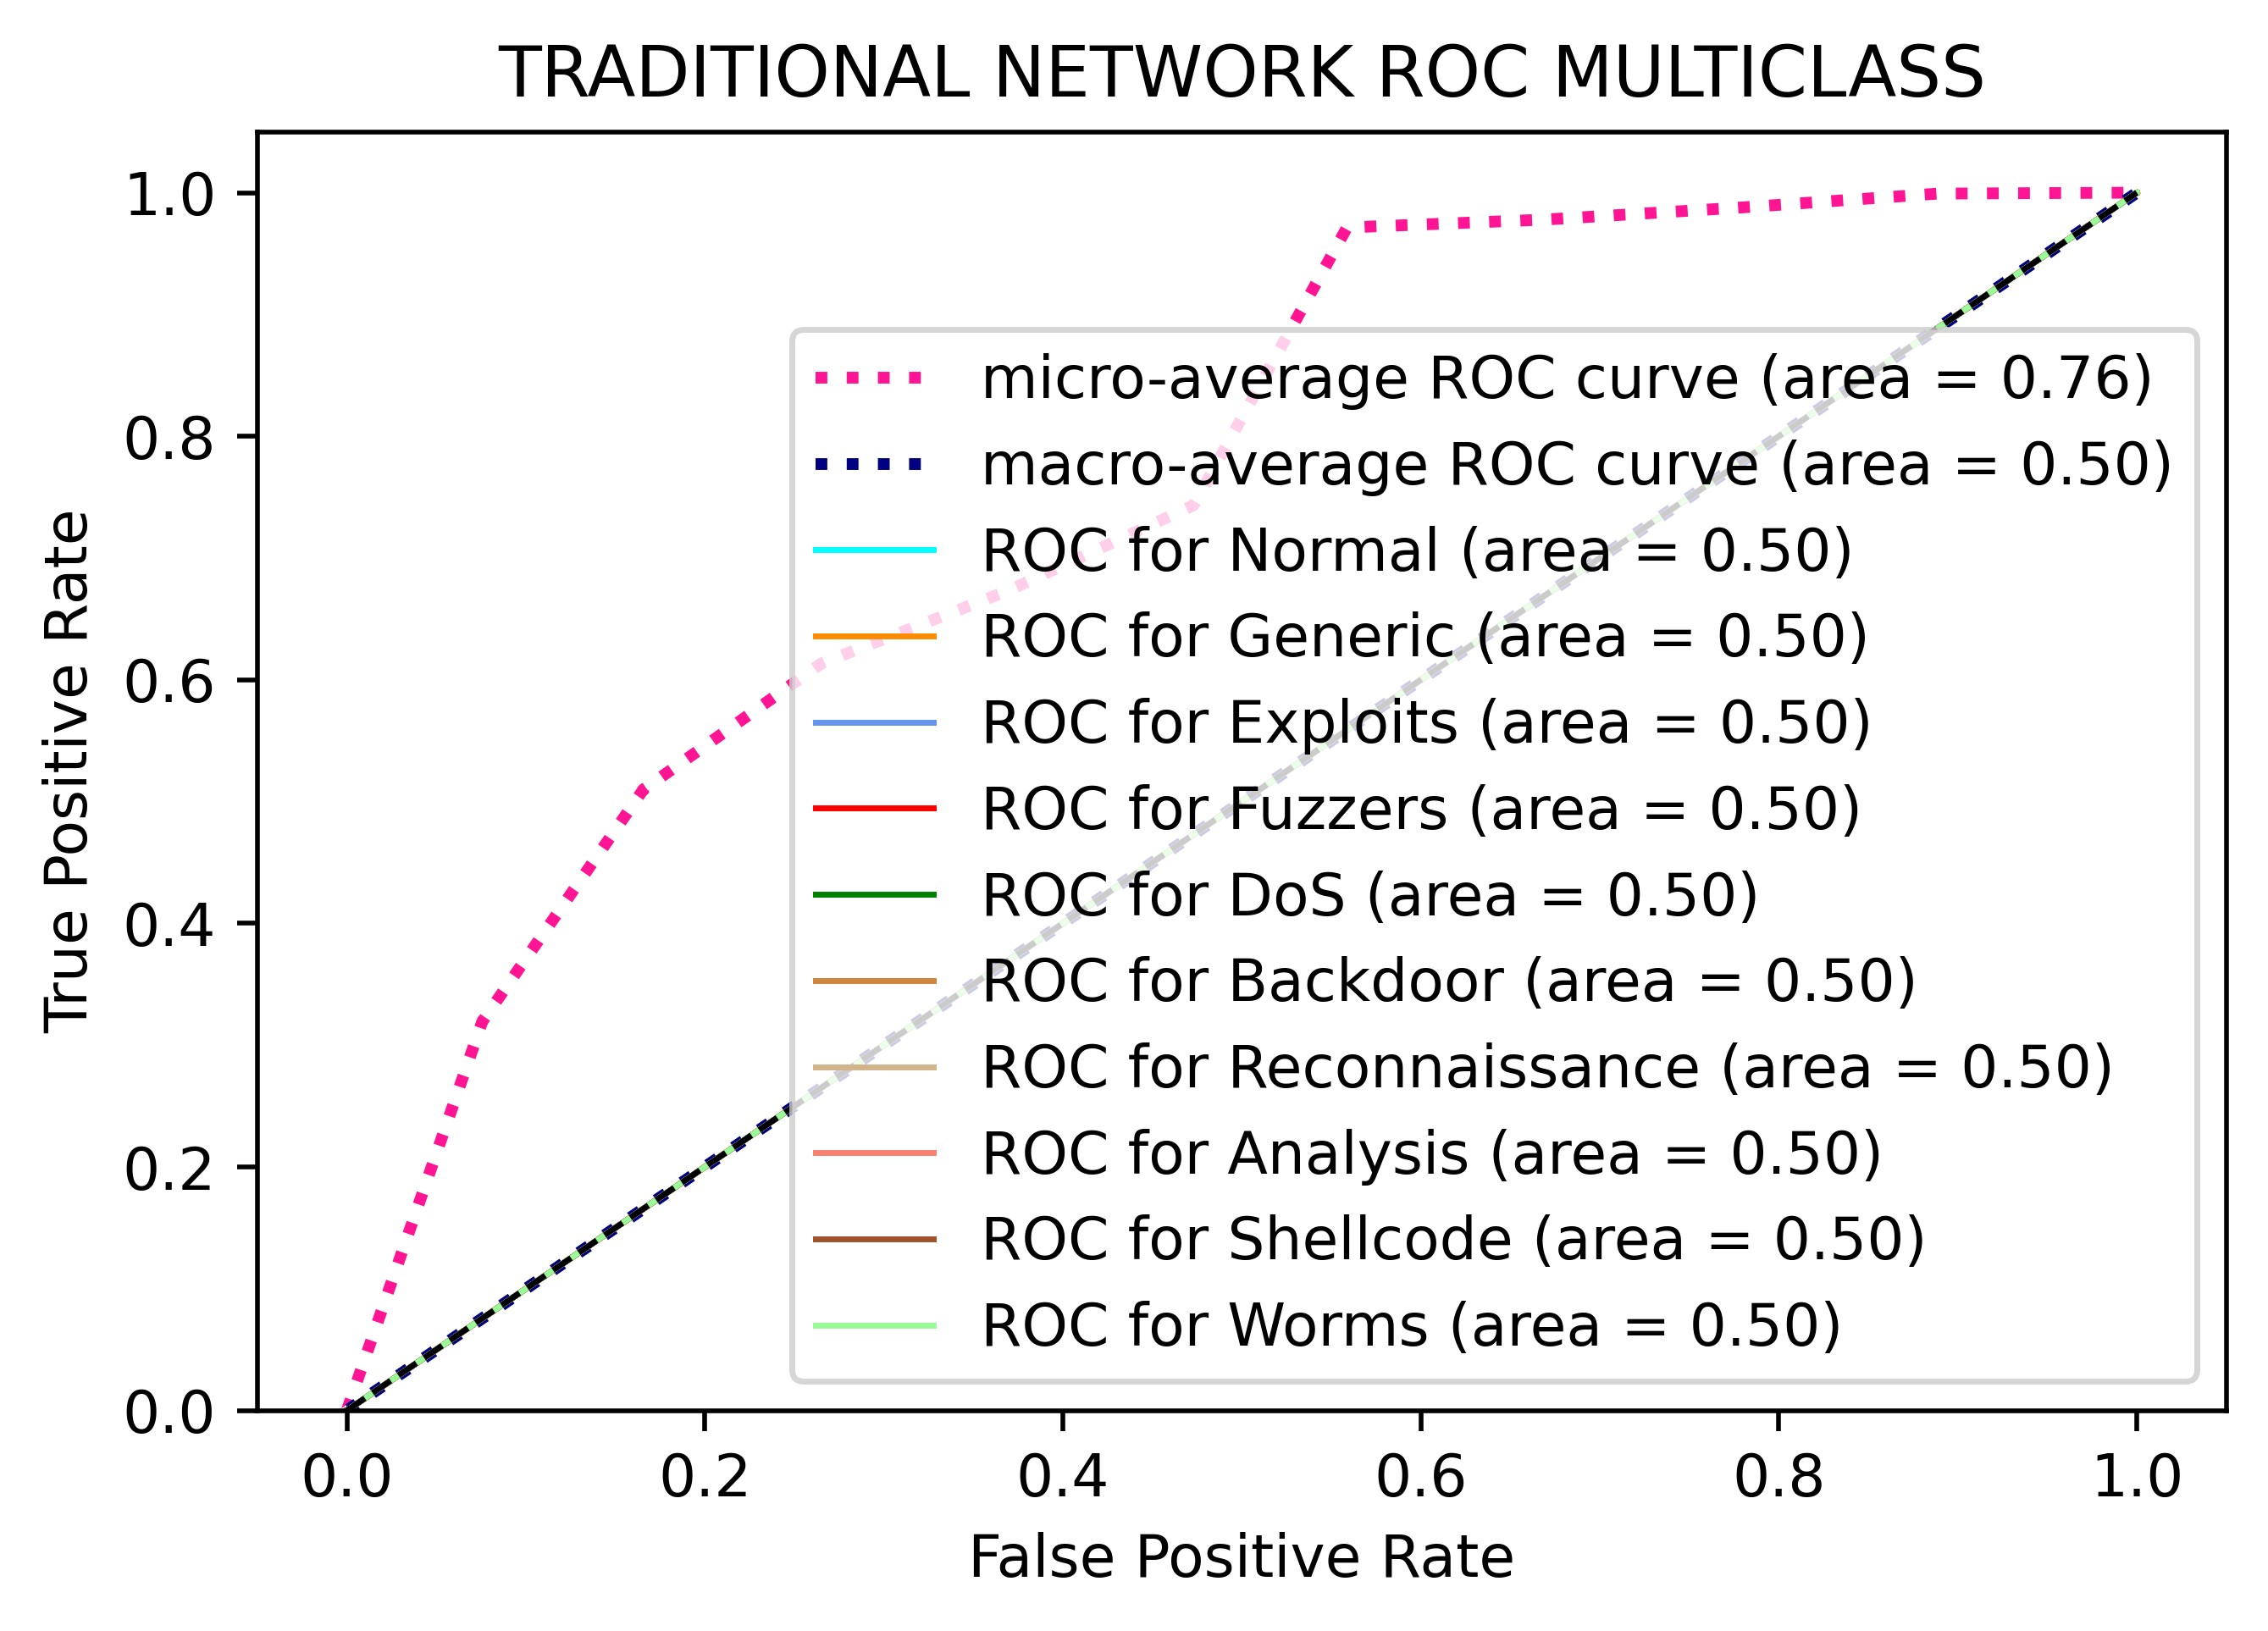

In [26]:
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","red","green","peru","tan","salmon","sienna","palegreen"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1,
        label="ROC for {0} (area = {1:0.2f})".format(CLASSES[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
# plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TRADITIONAL NETWORK ROC MULTICLASS")
plt.legend(loc="lower right")
plt.show()

In [27]:
MODELS_RESULTS

{'TRADITIONAL-NETWORK': {'train': {'loss': 0.9114717841148376,
   'accuracy': 0.7192135453224182,
   'precision': 0.7509673237800598,
   'recall': 0.6865710020065308,
   'auc': 0.9525710940361023,
   'prc': 0.7621419429779053},
  'validation': {'loss': 1.3663922548294067,
   'accuracy': 0.6814234256744385,
   'precision': 0.7156385183334351,
   'recall': 0.6516669988632202,
   'auc': 0.9265009760856628,
   'prc': 0.6898188591003418},
  'test': {'loss': 2.356973171234131,
   'accuracy': 0.31934913992881775,
   'precision': 0.319347083568573,
   'recall': 0.3193434476852417,
   'auc': 0.7546100616455078,
   'prc': 0.24010318517684937}}}

In [28]:
pd.DataFrame(MODELS_RESULTS['TRADITIONAL-NETWORK'])

,train,validation,test
loss,0.911472,1.366392,2.356973
accuracy,0.719214,0.681423,0.319349
precision,0.750967,0.715639,0.319347
recall,0.686571,0.651667,0.319343
auc,0.952571,0.926501,0.754610
prc,0.762142,0.689819,0.240103
